# Preprocessing of Calcium Signals

Get the example data file:

https://drive.google.com/file/d/1tjOfxj1WuvMF3uBUHLXTGfs6dUUr1QaC/view?usp=drive_link

The code below assume that you have it in your "Downloads" folder, modify the `filename` location otherwise

### Methods

Raw fluorescence traces were first corrected for neuropil contamination by subtracting the time-varying neuropil signal of each ROI using a fixed scaling coefficient of 0.7 (Dipoppa et al., 2018). Then, to be able to compare activity across cells and mouse lines, fluorescence signals were then normalized. To do this, we used the ΔF/F0 method, calculated using the following formula: (F-F0)/F0, where F is the fluorescence and F0 is the baseline fluorescence. The baseline fluorescence was calculated by tracking the lower 5th percentile over a sliding window of 2min followed by a Gaussian smoothing with a 2min width. ROIs with baseline fluorescence reaching negative values (i.e. with too high neuropil signals to isolate cellular activity) were discarded from the analysis.

see the function `compute_dFoF` in  [Calcium.py](./Calcium.py)

In [1]:
import numpy as np
import matplotlib.pylab as plt
from Calcium import *

## Baseline determination to compute $\Delta$F/F

I illustrate below a few different options to determine the baseline of a signal

In [2]:
N = 5 # rois
t = np.linspace(0, 1, int(1e3))
x = np.random.randn(N,len(t))+2*(1-t)
sWindow = 30
percentile = 10

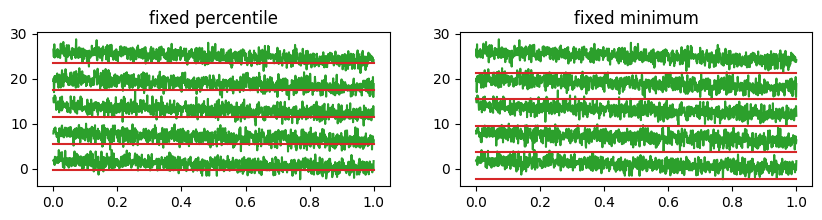

In [3]:
fig, AX = plt.subplots(1, 2, figsize=(10,2))

for ax, title, x0 in zip(AX,
                  ['fixed percentile', 'fixed minimum'],
                  [compute_percentile(x, percentile),
                   compute_minimum(x)]):
    ax.set_title(title)
    for roi in range(N):
        ax.plot(t, 6*roi+x[roi,:], color='tab:green')
        ax.plot(t, 6*roi+x0[roi,:], color='tab:red')

Text(0, 0.5, 'with smoothing')

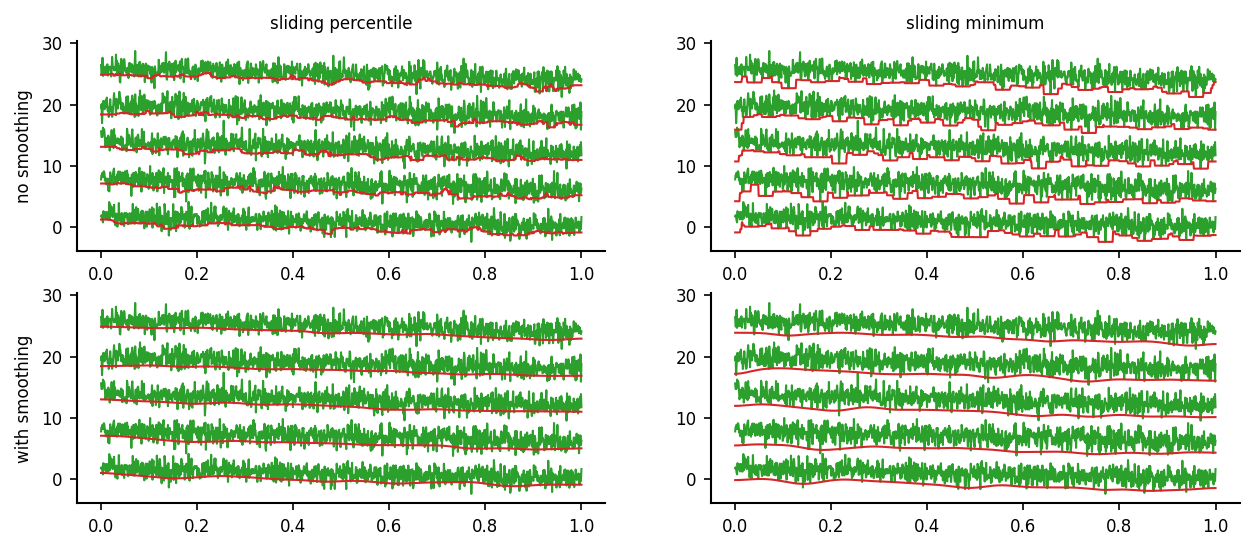

In [13]:
fig, AX = plt.subplots(2, 2, figsize=(10,4))

for ax, title, x0 in zip(AX[0],
                  ['sliding percentile', 'sliding minimum'],
                  [compute_sliding_percentile(x, percentile, sWindow),
                   compute_sliding_minimum(x, sWindow)]):
    ax.set_title(title)
    for roi in range(N):
        ax.plot(t, 6*roi+x[roi,:], color='tab:green')
        ax.plot(t, 6*roi+x0[roi,:], color='tab:red')
for ax, x0 in zip(AX[1],
                  [compute_sliding_percentile(x, percentile, sWindow, with_smoothing=True),
                   compute_sliding_minimum(x, sWindow, with_smoothing=True)]):
    for roi in range(N):
        ax.plot(t, 6*roi+x[roi,:], color='tab:green')
        ax.plot(t, 6*roi+x0[roi,:], color='tab:red')
AX[0][0].set_ylabel('no smoothing')
AX[1][0].set_ylabel('with smoothing')

## Illustration of discarding criteria

In [14]:
import numpy as np
import matplotlib.pylab as plt
import os, sys
from scipy import stats
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'physion', 'src'))
from physion.analysis.read_NWB import Data
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'physion', 'src', 'physion', 'utils'))
import plot_tools as pt
from Calcium import compute_F0

In [26]:
dFoF_options = dict(\
    method_for_F0='percentile',
    percentile=5.,
    neuropil_correction_factor=1.)

In [27]:
# modify if it is not in your "Downloads" folder:
filename = os.path.join(os.path.expanduser('~'), 'Downloads', '2023_12_20-15-27-46.nwb')
data = Data(filename)
# we first perform the dFoF determination with the above params
#    (this restrict the available ROIs in the future)
data.build_dFoF(**dFoF_options)
valid = data.valid_roiIndices
rejected = [i for i in range(data.nROIs) if (i not in valid)]
# we re-initialize the fluo and neuropil to get back to all ROIs
data.initialize_ROIs(valid_roiIndices=None)
data.build_rawFluo()
data.build_neuropil()

NWB-file reading time: 102.5ms

calculating dF/F with method "percentile" [...]

  ** 8 ROIs were discarded with the positive F0 criterion (11.0%) ** 

-> dFoF calculus done !  (calculation took 0.0s)


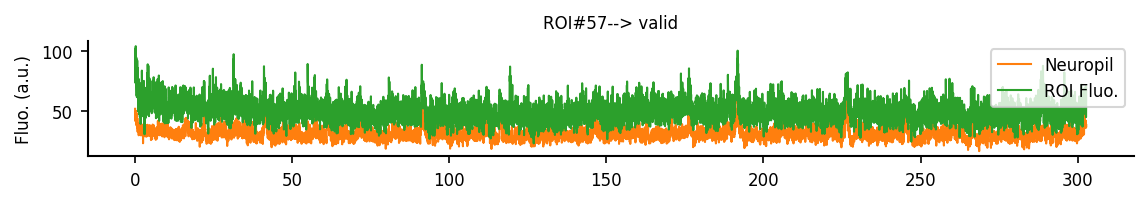

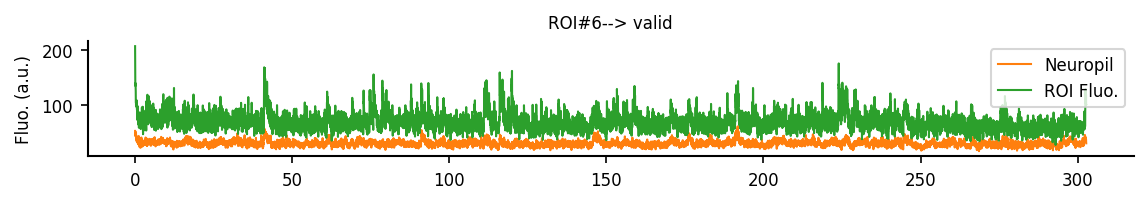

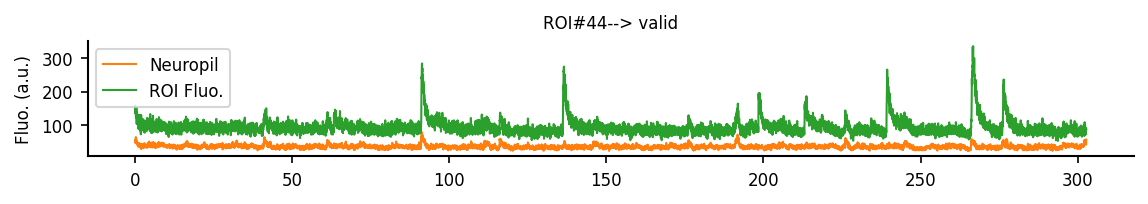

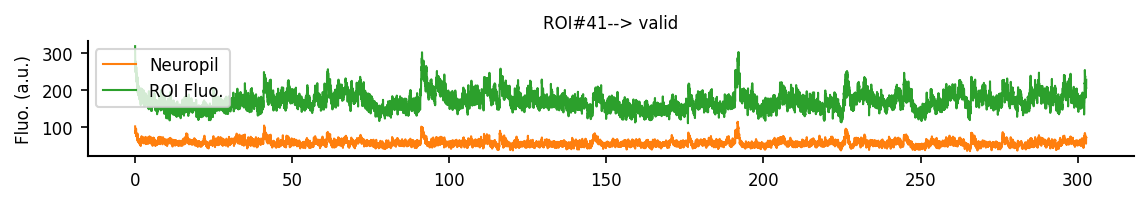

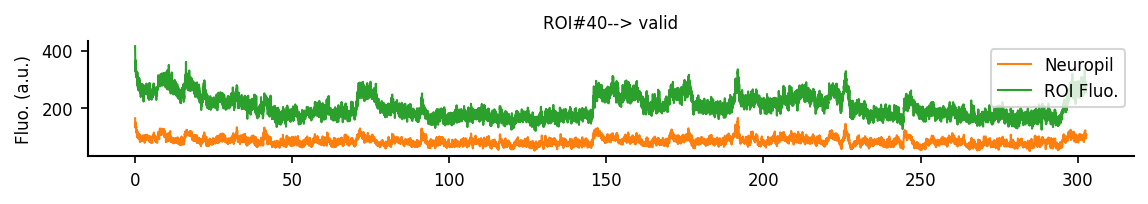

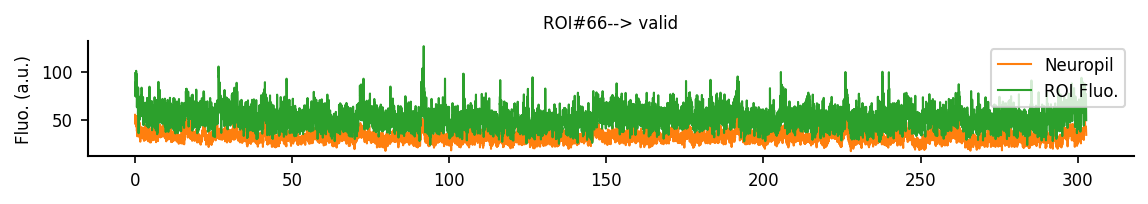

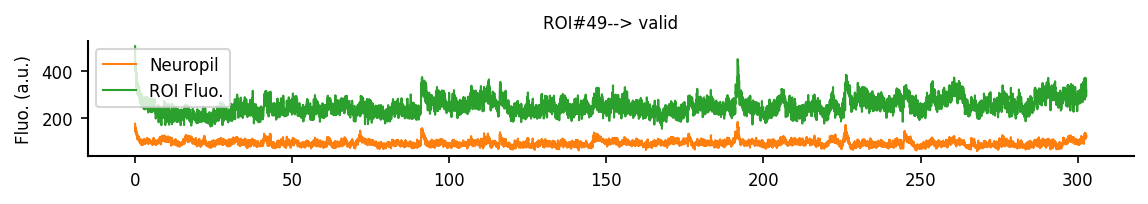

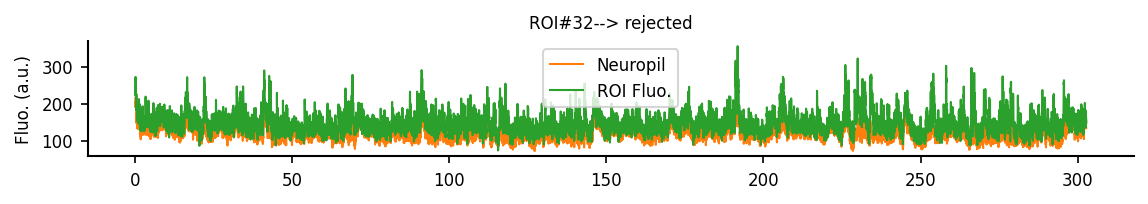

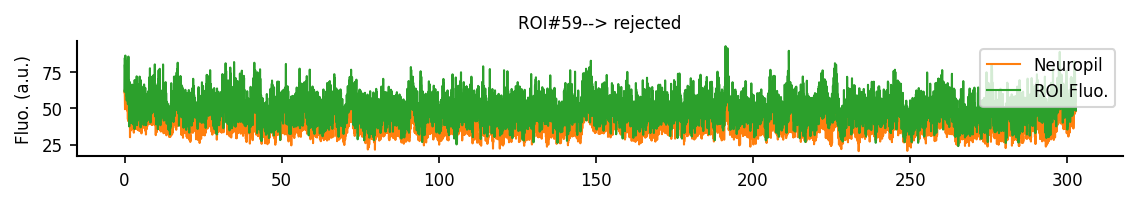

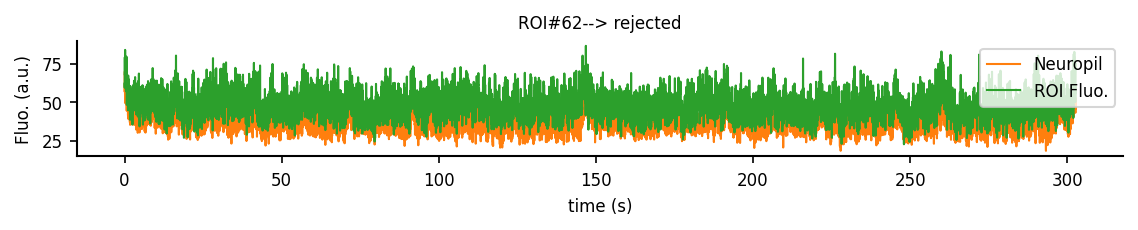

In [28]:
for roi in np.concatenate([np.random.choice(valid, 7, replace=False),
                           np.random.choice(rejected, min([3, len(rejected)]), replace=False)]):
    fig, ax = plt.subplots(figsize=(9,1.))
    plt.plot(data.t_dFoF, data.neuropil[roi,:], label='Neuropil', color='tab:orange')
    plt.plot(data.t_dFoF, data.rawFluo[roi,:], label='ROI Fluo.', color='tab:green')
    plt.title('ROI#%i' % (roi+1)+('--> valid' if roi in valid else '--> rejected'))
    plt.legend()
    plt.ylabel('Fluo. (a.u.)')
plt.xlabel('time (s)');

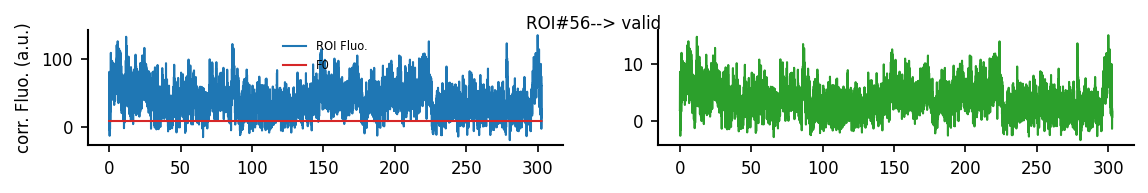

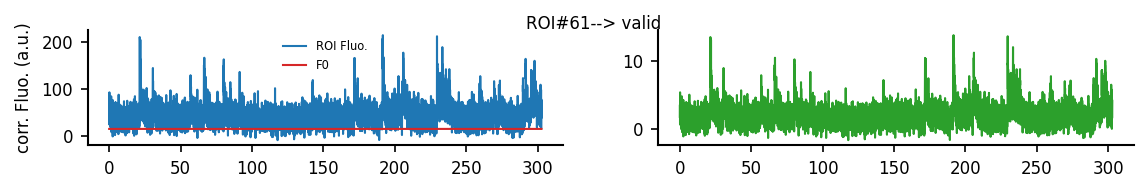

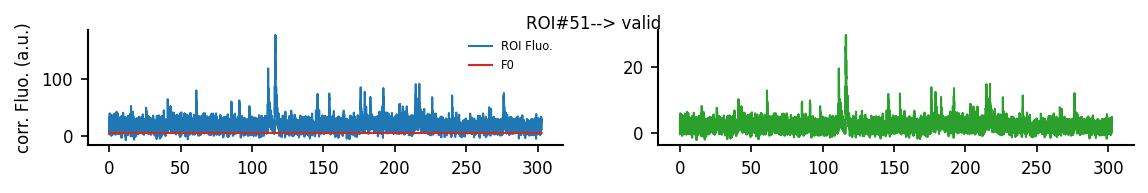

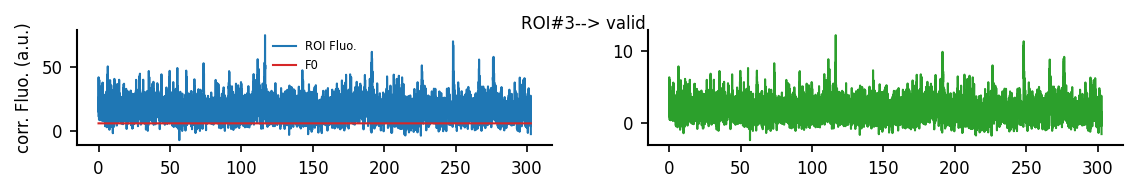

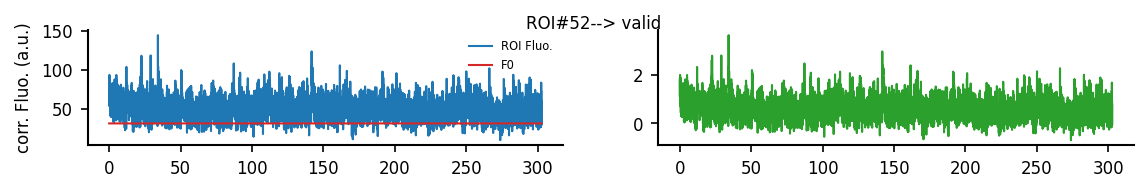

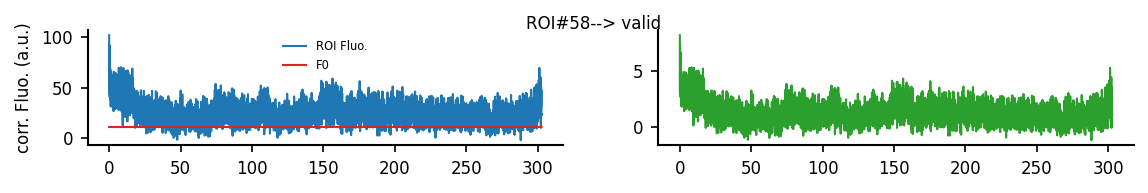

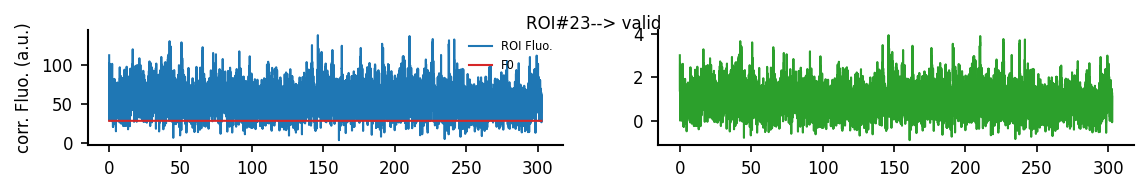

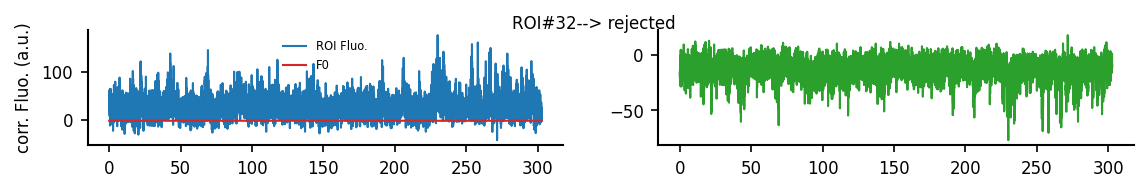

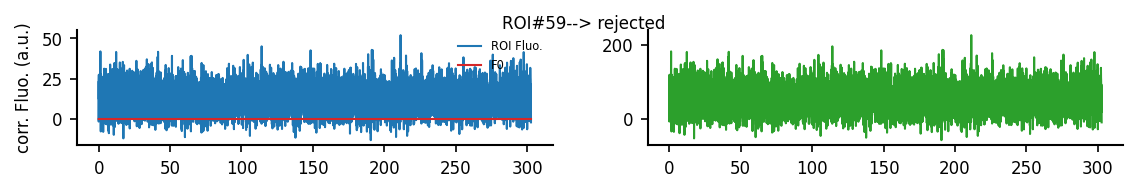

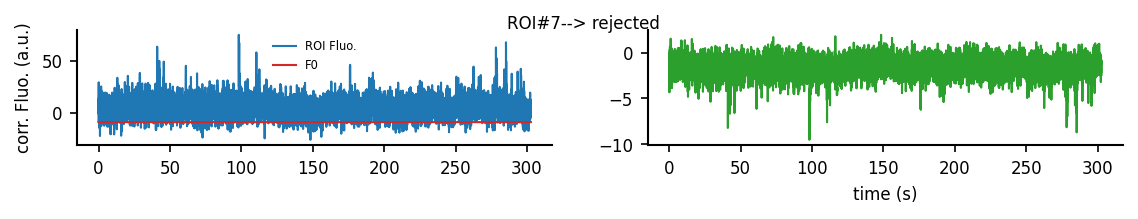

In [30]:
correctedFluo = data.rawFluo-dFoF_options['neuropil_correction_factor']*data.neuropil
baseline = compute_F0(data, correctedFluo, 
                      method='percentile',
                      percentile=dFoF_options['percentile'])
np.random.seed(1)
for roi in np.concatenate([np.random.choice(valid, 7, replace=False),
                           np.random.choice(rejected, min([3, len(rejected)]), replace=False)]):
    fig, AX = plt.subplots(1, 2, figsize=(9,1.))
    AX[0].plot(data.t_dFoF, correctedFluo[roi,:], label='ROI Fluo.', color='tab:blue')
    AX[0].plot(data.t_dFoF, baseline[roi,:], label='F0', color='tab:red')
    dFoF = (correctedFluo[roi,:]-baseline[roi,:])/baseline[roi,:]
    try:
        AX[1].plot(data.t_dFoF, dFoF, color='tab:green')
    except BaseException as be:
        pass
    fig.suptitle('ROI#%i' % (roi+1)+('--> valid' if roi in valid else '--> rejected'))
    AX[0].legend(frameon=False, fontsize='x-small')
    AX[0].set_ylabel('corr. Fluo. (a.u.)')
plt.xlabel('time (s)');

## Deconvolution

In [64]:
from dcnv import oasis, preprocess

TAU = 1.3 # s , decay of the Calcium Indicator, here GCamp6s

data.build_dFoF()

Dcnv = oasis(data.dFoF, len(data.t_dFoF), TAU, 1./data.CaImaging_dt)


calculating dF/F with method "percentile" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)


Text(0.5, 0, 'time (s)')

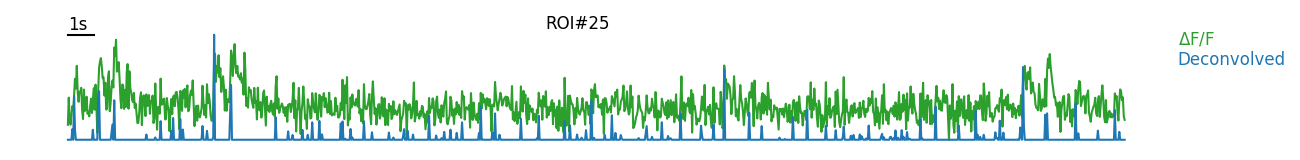

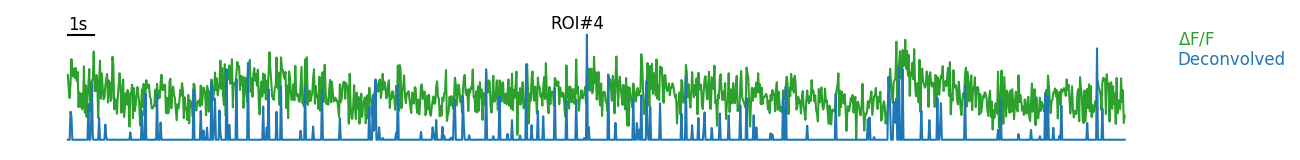

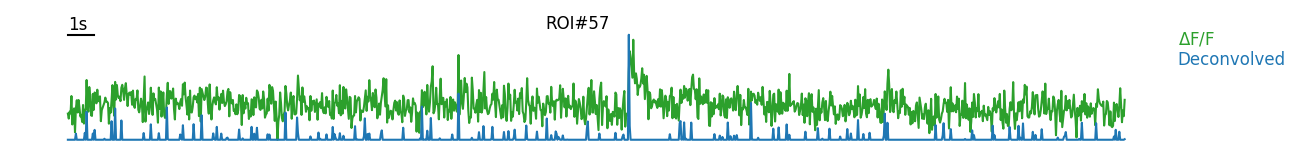

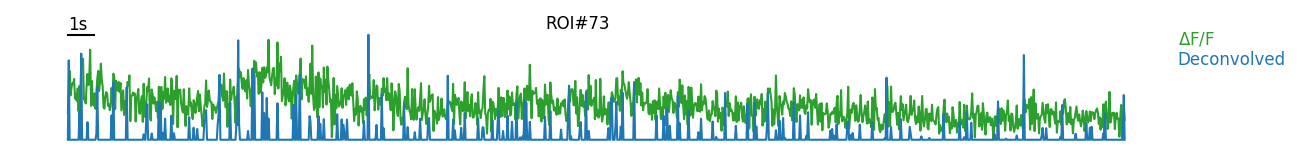

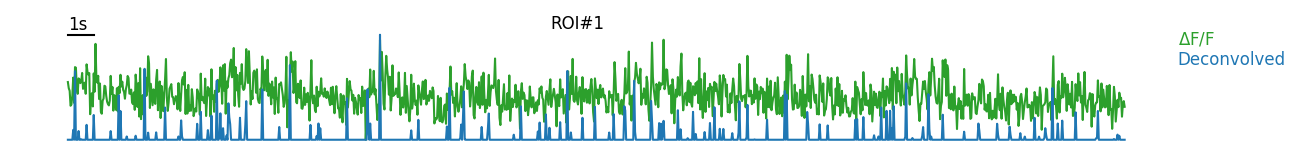

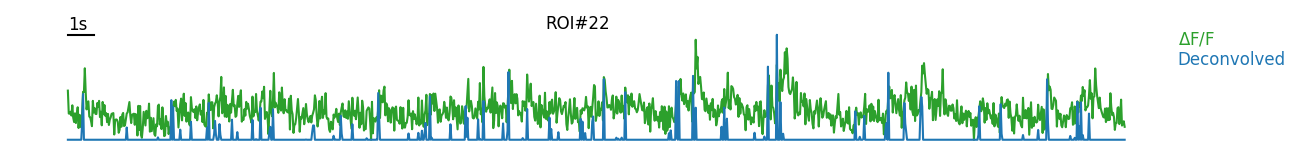

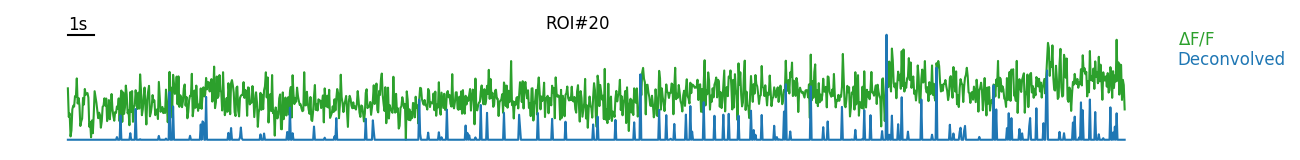

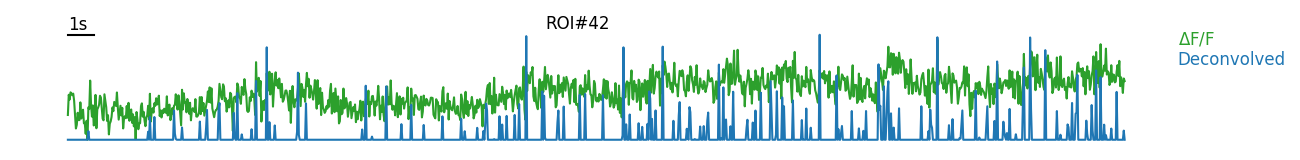

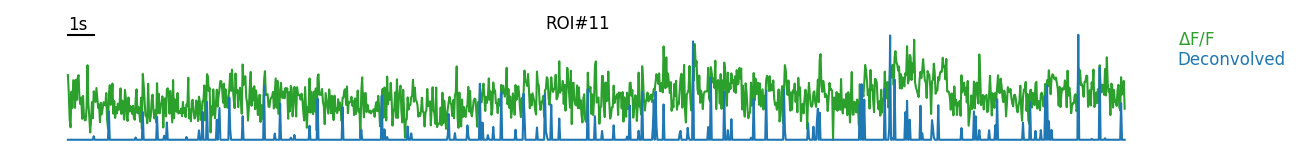

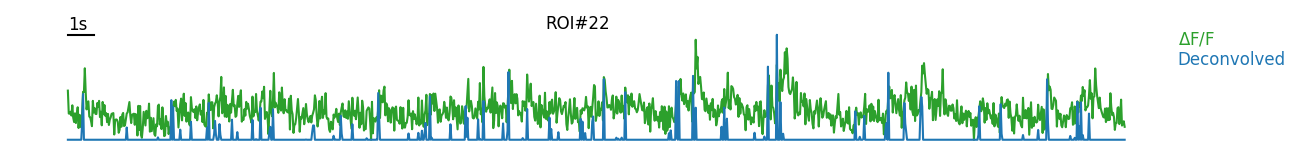

In [68]:
tzoom = [10,50]

np.random.seed(3)
for roi in np.random.choice(range(data.nROIs), 10):
    fig, ax = plt.subplots(1, figsize=(10,1))
    ax2 = ax.twinx()
    cond = (data.t_dFoF>tzoom[0]) & (data.t_dFoF<tzoom[1])
    ax.plot(data.t_dFoF[cond], data.dFoF[roi,cond], label='$\Delta$F/F', color='tab:green')
    ax2.plot(data.t_dFoF[cond], Dcnv[roi,cond], label='Deconv.', color='tab:blue')
    fig.suptitle('ROI#%i' % (roi+1))
    ax.annotate('$\Delta$F/F', (1,1), va='top', xycoords='axes fraction', color='tab:green')
    ax2.annotate('\nDeconvolved', (1,1), va='top', xycoords='axes fraction', color='tab:blue')
    ax.set_ylabel('(a.u.)')
    ax.axis('off')
    ax2.axis('off')
    ax.plot(tzoom[0]+np.arange(2), ax.get_ylim()[1]*np.ones(2), 'k-')
    ax.annotate('1s', (tzoom[0], ax.get_ylim()[1]))
    
ax.set_xlabel('time (s)')